In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/120dog breeds-224.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/projectDataset224')

In [ ]:
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import applications
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint

In [ ]:
import pathlib
from keras.preprocessing.image import ImageDataGenerator


data_dir = pathlib.Path('/content/projectDataset224/120dog breeds-224')

data_train = data_dir / 'train'

test_dir = data_dir / 'test'


labels_csv = pd.read_csv('/content/drive/MyDrive/labels.csv')
labels_csv['id'] = [str(fname) + '.jpg' for fname in labels_csv['id']]

In [ ]:
batch_size = 16
img_size = 224

In [ ]:
# datagen = ImageDataGenerator(preprocessing_function = keras.applications.vgg16.preprocess_input, validation_split=0.2)

# train_generator = datagen.flow_from_dataframe(
#                         dataframe = labels_csv,
#                         directory = data_train,
#                         subset="training",
#                         x_col="id",
#                         y_col="breed",
#                         batch_size=batch_size,
#                         shuffle=True,
#                         class_mode="sparse",
#                         color_mode="rgb",
#                         target_size=(img_size, img_size))

# validation_generator = datagen.flow_from_dataframe(
#                         dataframe = labels_csv,
#                         directory = data_train,
#                         subset="validation",
#                         x_col="id",
#                         y_col="breed",
#                         batch_size=batch_size,
#                         shuffle=True,
#                         class_mode="sparse",
#                         color_mode="rgb",
#                         target_size=(img_size, img_size))

train_datagen = ImageDataGenerator(
    preprocessing_function=keras.applications.vgg16.preprocess_input,
    validation_split=0.2,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.05,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)


train_generator = train_datagen.flow_from_dataframe(
    dataframe=labels_csv,
    directory=data_train,
    subset='training',
    x_col='id',
    y_col='breed',
    batch_size=batch_size,
    shuffle=True,
    class_mode='sparse',
    color_mode='rgb',
    target_size=(img_size, img_size)
)

validation_datagen = ImageDataGenerator(
    preprocessing_function = keras.applications.vgg16.preprocess_input, 
    validation_split=0.2
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=labels_csv,
    directory=data_train,
    subset='validation',
    x_col='id',
    y_col='breed',
    batch_size=batch_size,
    shuffle=True,
    class_mode='sparse',
    # class_mode='categorical',
    color_mode='rgb',
    target_size=(img_size, img_size)
)

Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


In [ ]:
vgg16 = applications.vgg16.VGG16(include_top=False, weights='imagenet',input_shape=(224,224,3))

for layer in vgg16.layers:
    layer.trainable=False

model = Sequential()
model.add(vgg16)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(120, activation='softmax'))
model.summary()

optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4, rho=0.9)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

58889256/58889256 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 512)        2048      
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                         

In [ ]:
# history_vgg = model.fit(train_generator, epochs=50, verbose = 1,
#                         validation_data=validation_generator)

from keras.callbacks import ModelCheckpoint, EarlyStopping


checkpoint_cb = ModelCheckpoint("/content/drive/MyDrive/VGG16-Epoch50DataAugmentationHigh.h5", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)


history_vgg = model.fit(train_generator, epochs=50, verbose = 1,
                        validation_data=validation_generator,
                        callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50
512/512 [==============================] - 148s 267ms/step - loss: 4.0068 - accuracy: 0.1044 - val_loss: 2.1444 - val_accuracy: 0.4227
Epoch 2/50
512/512 [==============================] - 139s 272ms/step - loss: 2.8796 - accuracy: 0.2598 - val_loss: 1.6483 - val_accuracy: 0.5509
Epoch 3/50
512/512 [==============================] - 136s 266ms/step - loss: 2.5354 - accuracy: 0.3313 - val_loss: 1.4947 - val_accuracy: 0.5572
Epoch 4/50
512/512 [==============================] - 138s 269ms/step - loss: 2.4011 - accuracy: 0.3580 - val_loss: 1.4341 - val_accuracy: 0.5939
Epoch 5/50
512/512 [==============================] - 138s 270ms/step - loss: 2.2585 - accuracy: 0.3910 - val_loss: 1.3400 - val_accuracy: 0.6169
Epoch 6/50
512/512 [==============================] - 137s 268ms/step - loss: 2.2179 - accuracy: 0.3992 - val_loss: 1.3468 - val_accuracy: 0.6115
Epoch 7/50
512/512 [==============================] - 135s 265ms/step - loss: 2.1403 - accuracy: 0.4183 - val_loss: 1.2717 -

In [ ]:
model.save('/content/drive/MyDrive/VGG16-Epoch50DataAugmentationHighVersion2.h5')

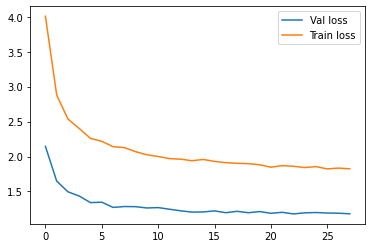

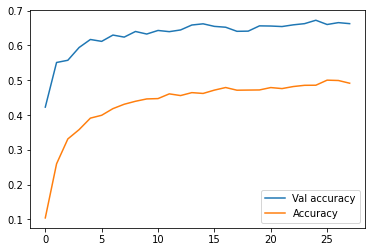

In [ ]:
plt.figure()
plt.plot(history_vgg .history['val_loss'], label = 'Val loss')
plt.plot(history_vgg .history['loss'], label = 'Train loss')
plt.legend()
plt.show()
plt.figure()
plt.plot(history_vgg .history['val_accuracy'], label = 'Val accuracy')
plt.plot(history_vgg .history['accuracy'], label = 'Accuracy')
plt.legend()
plt.show()